## Mall Customer Segmentation using K-Means Clustering with Python

### Executive Summary

This analysis aimed to uncover distinct customer segments through clustering, using key behavioral and demographic variables. While individual features like age, income, or tenure did not strongly differentiate campaign respondents, clustering allowed us to isolate meaningful patterns in spending behavior, family composition, and marketing responsiveness.

Notably:

Cluster 2 is the most responsive to marketing campaigns, typically comprising younger individuals with no kids, and high spenders.

Cluster 1 consists of larger, family-oriented households with moderate income and high purchases, indicating a reliable customer base.

Cluster 3, although diverse and younger, shows low spending and low engagement, suggesting it may not be a profitable target.

Income and spending are moderately correlated, while campaign acceptance shows weak correlation with individual features.

Recommendations include targeting Cluster 2 for future marketing, tailoring strategies for Cluster 1 families, and re-evaluating resource allocation to Cluster 3.

importing necessary libraries

## ANALYSIS

In [26]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
import seaborn as sn
import matplotlib
from matplotlib import figure
from sklearn.preprocessing import StandardScaler
from yellowbrick.cluster import KElbowVisualizer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
plt.style.use("ggplot")
matplotlib.rcParams["figure.figsize"] = (9, 4)
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

## data cleaning

In [28]:
#loading dataset 
df = pd.read_csv(r"C:\Users\aSalami\Downloads\marketing_campaign.csv", sep='\t')
df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


In [29]:
#checking the datatape information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

In [30]:
df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'], errors='coerce')

# Step 2: Find the rows with NaT
mask = df['Dt_Customer'].isna()
num_missing = mask.sum()

# Step 3: Generate random dates between 2012-01-01 and 2014-12-31
start_date = pd.to_datetime('2012-01-01')
end_date = pd.to_datetime('2014-12-31')
random_days = np.random.randint(0, (end_date - start_date).days + 1, num_missing)
random_dates = start_date + pd.to_timedelta(random_days, unit='D')

# Step 4: Fill the NaT values with the random dates
df.loc[mask, 'Dt_Customer'] = random_dates

In [31]:
#dropping null values 
df = df.dropna()

#extracting age column from year_birth  
df.insert(2, 'Age', pd.Timestamp.today().year - df['Year_Birth'])

#remove rows where the marital_status is Absurd or YOLO
df = df[~df['Marital_Status'].isin(['Absurd', 'YOLO'])]

#getting total number of children in the household, 
df.insert(6, 'Children', df['Kidhome'] + df['Teenhome'])

# getting total number of people in the household 
df.insert(9, 'Family_Size', df.apply(
    lambda row: (1 if row['Marital_Status'] in ['Single', 'Divorced', 'Widow', 'Alone'] else 2) + row['Children'],
    axis=1
))

#adding a column for parent_flag, 1 if a parent and 0 if not a parent 
df.insert(3,'Is_Parent', np.where(df.Children> 0, 1, 0))

#checking how long client have been a customer in years 
df.insert(11, 'Customer_for', pd.Timestamp.today().year - df['Dt_Customer'].dt.year)

#calculating total amount spent 
df.insert(18, 'total_spent', df['MntWines'] + df['MntFruits'] + df['MntMeatProducts'] + df['MntFishProducts'] + df['MntSweetProducts'] + df['MntGoldProds'])

#calculating total count of purchases
df.insert(23, 'total_purchase', df['NumDealsPurchases']+df['NumWebPurchases']+df['NumCatalogPurchases']+df['NumStorePurchases'])

#getting accepted campaign_flag 
df.insert(28, 'accepted_campaign_flag', df[['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5']].apply(lambda row: 1 if row.any() else 0, axis=1)) 

#renaming columns 
df = df.rename(columns = {'MntWines':'Wines', 'MntFruits':'Fruits', 'MntMeatProducts':'Meat', 'MntFishProducts':'Fish', 'MntSweetProducts':'Sweet','MntGoldProds':'Gold'})

#replacing values in education for bettter clarification
df['Education']=df['Education'].replace({'Basic':'Undergraduate','2n Cycle':'Undergraduate', 'Graduation':'Graduate', 'Master':'Postgraduate', 'PhD':'Postgraduate'})

#dropping some column 
df = df.drop(['Year_Birth', 'Marital_Status', 'ID', 'Z_CostContact', 'Z_Revenue', 'Dt_Customer'], axis = 1)

#preview after cleaning 
df.head()

,Age,Is_Parent,Education,Income,Children,Kidhome,Teenhome,Family_Size,Customer_for,Recency,...,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,accepted_campaign_flag,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response
0,68,0,Graduate,58138.0,0,0,0,1,13,58,...,4,7,0,0,0,0,0,0,0,1
1,71,1,Graduate,46344.0,2,1,1,3,11,38,...,2,5,0,0,0,0,0,0,0,0
2,60,0,Graduate,71613.0,0,0,0,2,13,26,...,10,4,0,0,0,0,0,0,0,0
3,41,1,Graduate,26646.0,1,1,0,3,11,26,...,4,6,0,0,0,0,0,0,0,0
4,44,1,Postgraduate,58293.0,1,1,0,3,11,94,...,6,5,0,0,0,0,0,0,0,0


In [32]:
#checking dataset info after cleaning 
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2212 entries, 0 to 2239
Data columns (total 31 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Age                     2212 non-null   int64  
 1   Is_Parent               2212 non-null   int64  
 2   Education               2212 non-null   object 
 3   Income                  2212 non-null   float64
 4   Children                2212 non-null   int64  
 5   Kidhome                 2212 non-null   int64  
 6   Teenhome                2212 non-null   int64  
 7   Family_Size             2212 non-null   int64  
 8   Customer_for            2212 non-null   int32  
 9   Recency                 2212 non-null   int64  
 10  Wines                   2212 non-null   int64  
 11  Fruits                  2212 non-null   int64  
 12  Meat                    2212 non-null   int64  
 13  Fish                    2212 non-null   int64  
 14  total_spent             2212 non-null   int64

## data exploration

In [33]:
#performing a descriptive stats on dataset
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,2212.0,56.188969,11.982065,29.0,48.00,55.0,66.00,132.0
Is_Parent,2212.0,0.714738,0.451641,0.0,0.00,1.0,1.00,1.0
Income,2212.0,52232.510850,25187.455359,1730.0,35233.50,51381.5,68522.00,666666.0
Children,2212.0,0.948011,0.749196,0.0,0.00,1.0,1.00,3.0
Kidhome,2212.0,0.442586,0.537052,0.0,0.00,0.0,1.00,2.0
Teenhome,2212.0,0.505425,0.544258,0.0,0.00,0.0,1.00,2.0
Family_Size,2212.0,2.594485,0.905097,1.0,2.00,3.0,3.00,5.0
Customer_for,2212.0,11.993219,0.767056,11.0,11.00,12.0,13.00,13.0
Recency,2212.0,49.050633,28.940794,0.0,24.00,49.0,74.00,99.0
Wines,2212.0,305.030741,337.611255,0.0,23.75,173.5,505.50,1493.0


In [34]:
#there seem to be someoutliers in the data 
#Dropping the outliers by setting a cap on Age and income. 
df = df[(df["Age"]<85)]
df = df[(df["Income"]<600000)]

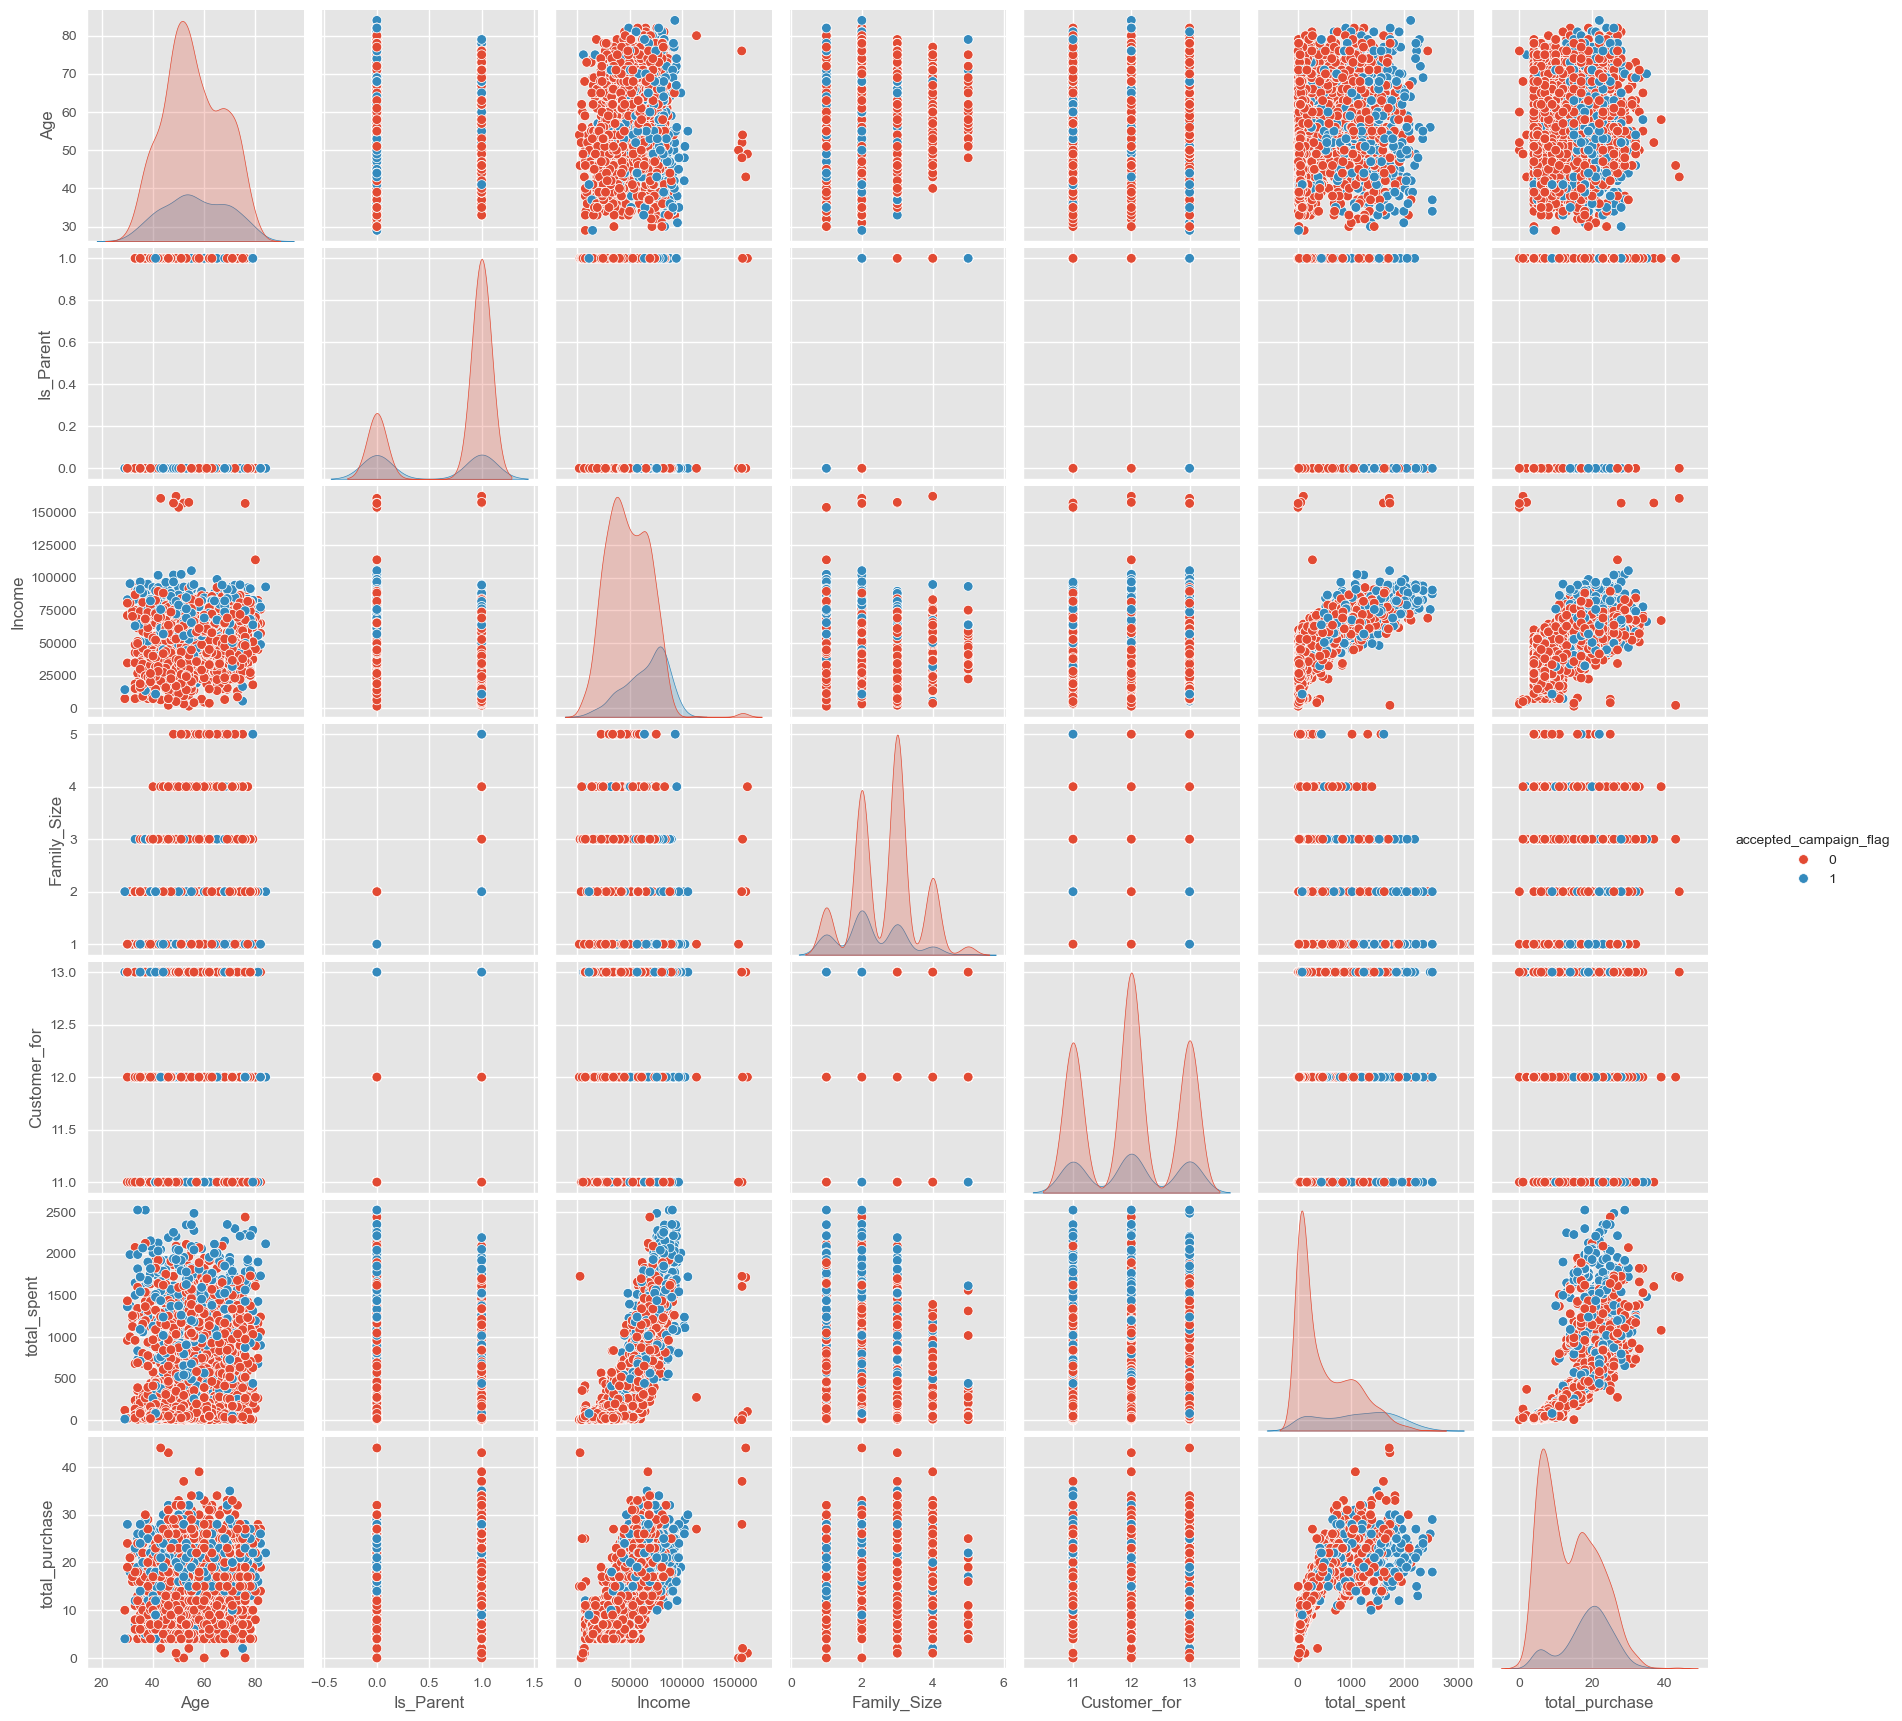

In [50]:
# Performing a pairplot plot a pairwise relationships in the dataset.
sn.pairplot(df_corr[['Age', 'Is_Parent', 'Income',  'Family_Size', 'Customer_for', 'total_spent', 'total_purchase', 'accepted_campaign_flag']], hue = 'accepted_campaign_flag')
plt.show()

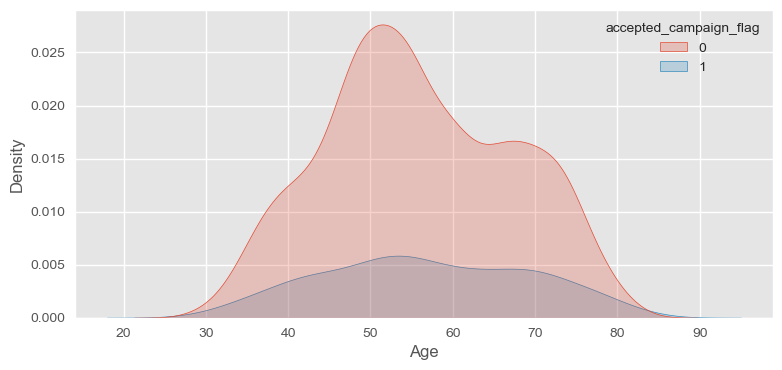

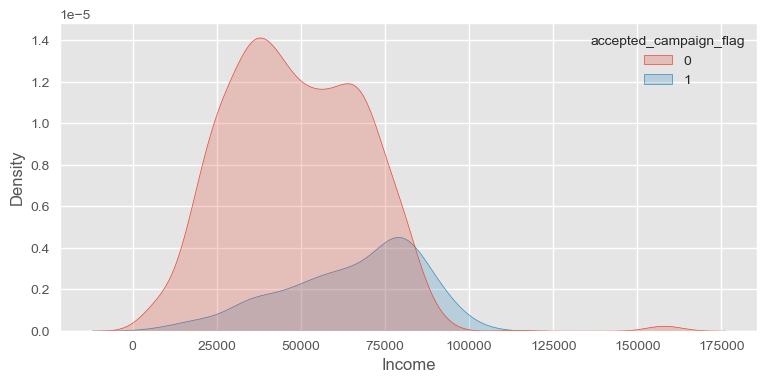

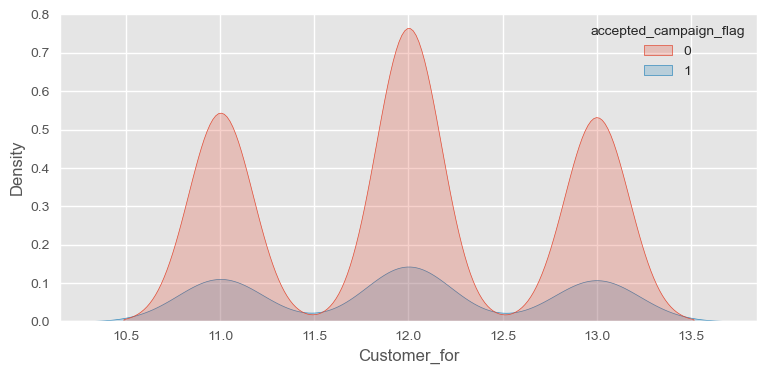

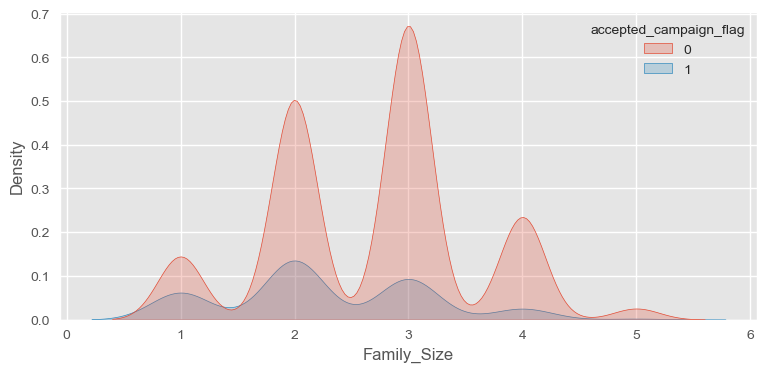

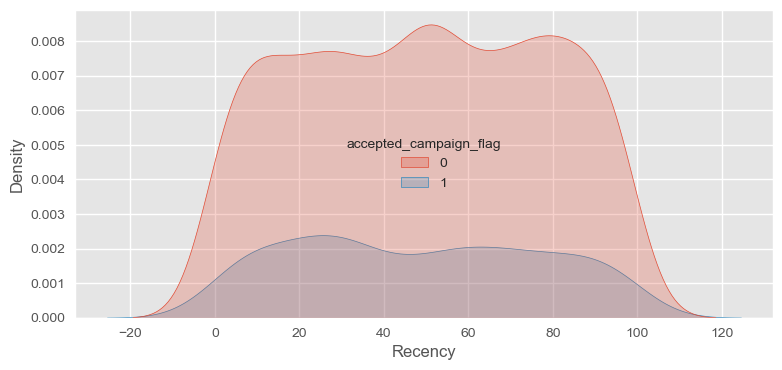

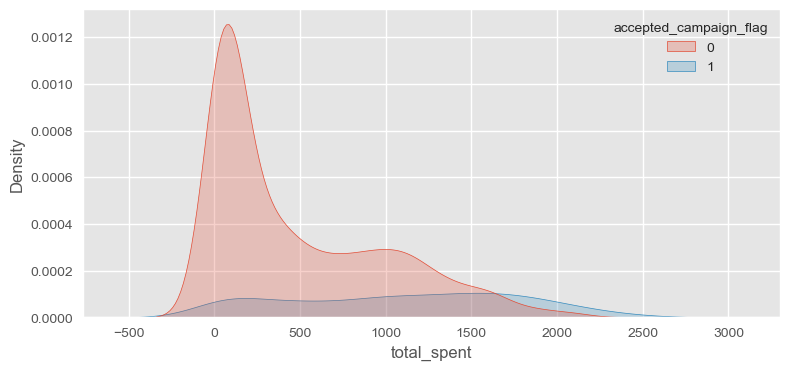

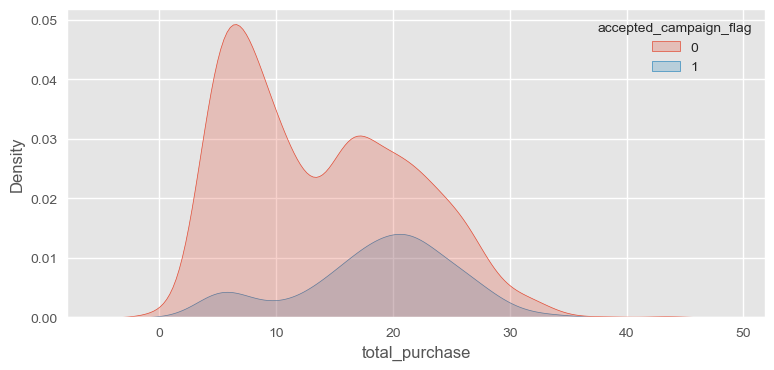

In [35]:
#Performing a Kernel Density Estimate (KDE) plot to visualize the distribution of observations in the dataset.
columns = ['Age', 'Income', 'Customer_for', 'Family_Size', 'Recency', 'total_spent', 'total_purchase']
for i in columns:
    plt.figure()
    sn.kdeplot(data = df, x = df[i], hue = df["accepted_campaign_flag"], shade = True)
plt.show()

1. Age vs. Campaign Acceptance
Both groups are concentrated around ages 40 to 70.
Campaigns seem to be more frequently accepted (though fewer in number) by customers in that age range, but the number of acceptances is much smaller compared to rejections.
The overlapping suggests age alone doesn't drastically separate the two groups, but it could still be a contributing factor.

2. Income vs. Campaign Acceptance
Most customers have an income below 150,000.
Those who accepted the campaign also tend to cluster in the same income range, but again, in smaller numbers.
The density spike is much higher for non-acceptors, suggesting income also isn't a strong differentiator, though extremely high incomes appear rarely.


3. Customer_for (How long someone has been a customer) vs. Campaign Acceptance
The x-axis shows time (presumably in years).
There are clear peaks at 11, 12, and 13 years of customer history.
Campaign non-acceptors (red) dominate at each of those durations.
Acceptors (blue) are present at similar points, just in smaller densities.
It looks like the length of time as a customer isn't a strong factor in distinguishing between acceptors and non-acceptors either.


4. Total Purchases vs. Campaign Acceptance
Most customers (both accepted and not) made between 5 to 25 purchases.
The peak for those who accepted the campaign is slightly higher in the purchase count than for those who didn't.
This suggests that people who accept campaigns tend to buy more frequently.


5. Total Spent vs. Campaign Acceptance
Customers who didn't accept (red) mostly spent less than $1000, with a sharp peak around that value.
Those who did accept (blue) are more evenly distributed and skewed right, indicating higher spending behavior.
This suggests that people who accept campaigns tend spend more


6. Family Size vs. Campaign Acceptance
Family size alone may not be a strong distinguishing factor for campaign acceptance.
However, individuals with a family size of 2 show a relatively higher density among acceptors compared to others — this could be a hint worth exploring further with other variables.

7. Recency vs. Campaign Acceptance
Recency is not a strong distinguishing factor for campaign acceptance.

## correlation analysis

In [54]:
#introducing catcodes for education column
df['education_catcode'] = df['Education'].astype("category").cat.codes
df_corr = df.drop('Education', axis=1) 
df = df.drop('education_catcode', axis=1) 
#checing for correlation
df_corr.corr(method = "pearson")

,Age,Is_Parent,Income,Children,Kidhome,Teenhome,Family_Size,Customer_for,Recency,Wines,...,NumWebVisitsMonth,AcceptedCmp3,accepted_campaign_flag,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,education_catcode
Age,1.000000,-0.010666,0.201482,0.093865,-0.238033,0.364127,0.079918,-0.008583,0.013744,0.166168,...,-0.121338,-0.061169,0.033151,0.070320,-0.015436,0.015920,0.007881,0.004646,-0.017849,-0.026065
Is_Parent,-0.010666,1.000000,-0.402653,0.799418,0.520435,0.587145,0.691856,-0.042228,0.004471,-0.342835,...,0.474573,-0.005928,-0.237194,-0.077535,-0.346051,-0.278338,-0.081915,0.018007,-0.204274,-0.009806
Income,0.201482,-0.402653,1.000000,-0.342988,-0.514586,0.035531,-0.286046,-0.042032,0.007607,0.688382,...,-0.650091,-0.014965,0.314183,0.219951,0.394907,0.326616,0.104168,-0.027847,0.160786,-0.085890
Children,0.093865,0.799418,-0.342988,1.000000,0.687995,0.697976,0.849469,-0.051839,0.019302,-0.353889,...,0.414765,-0.020009,-0.217278,-0.089001,-0.284043,-0.229409,-0.070309,0.032058,-0.167750,-0.007203
Kidhome,-0.238033,0.520435,-0.514586,0.687995,1.000000,-0.039496,0.582580,-0.041088,0.010170,-0.497672,...,0.447962,0.015623,-0.202611,-0.162778,-0.204430,-0.173946,-0.082194,0.036917,-0.076865,0.022970
Teenhome,0.364127,0.587145,0.035531,0.697976,-0.039496,1.000000,0.594735,-0.030830,0.016540,0.003832,...,0.129040,-0.042966,-0.099232,0.038083,-0.189365,-0.144221,-0.015700,0.007711,-0.155123,-0.032584
Family_Size,0.079918,0.691856,-0.286046,0.849469,0.582580,0.594735,1.000000,-0.068568,0.015346,-0.297535,...,0.344734,-0.027032,-0.180766,-0.077728,-0.224620,-0.184285,-0.059994,0.026858,-0.217662,0.004844
Customer_for,-0.008583,-0.042228,-0.042032,-0.051839,-0.041088,-0.030830,-0.068568,1.000000,0.017474,0.028698,...,0.093781,0.025085,-0.001303,0.011518,-0.020300,-0.041158,0.006141,0.013313,0.063272,-0.003337
Recency,0.013744,0.004471,0.007607,0.019302,0.010170,0.016540,0.015346,0.017474,1.000000,0.016362,...,-0.017111,-0.032585,-0.017036,0.017388,-0.000471,-0.021983,-0.001500,0.005667,-0.199624,-0.025691
Wines,0.166168,-0.342835,0.688382,-0.353889,-0.497672,0.003832,-0.297535,0.028698,0.016362,1.000000,...,-0.322003,0.061363,0.464101,0.373416,0.473478,0.351918,0.206332,-0.036429,0.246308,-0.027368


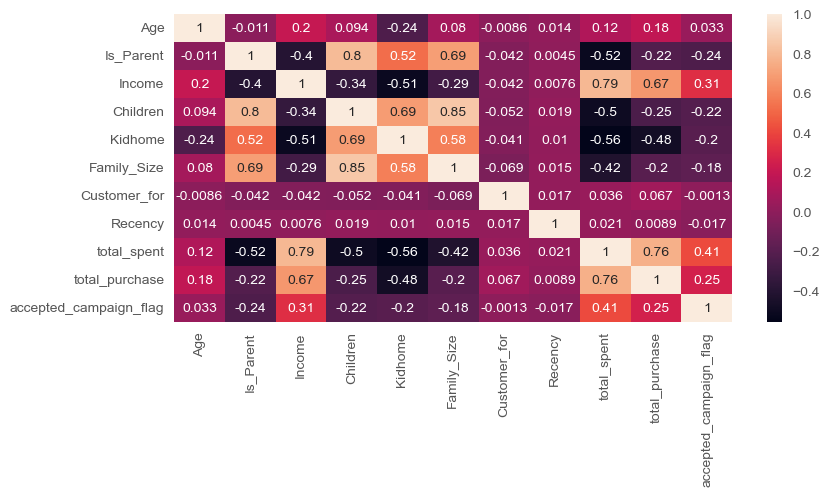

In [51]:
#Plotting a Heatmap for the correlation
sn.heatmap(df[['Age', 'Is_Parent', 'Income', 'Children', 'Kidhome', 'Family_Size', 'Customer_for', 'Recency', 'total_spent', 'total_purchase', 'accepted_campaign_flag']].corr(method = "pearson"), annot=True)
plt.show()

This correlation matrix heatmap, showing how different variables in a dataset relate to each other. Each cell represents the correlation coefficient between two variables, ranging from -1 (perfect negative correlation) to +1 (perfect positive correlation).

Key Observations:

Strong Positive Correlations (Close to +1):
Income & total_spent (0.79)
→ Higher income correlates with more spending.

total_spent & total_purchase (0.76)
→ Customers who spend more also make more purchases(expected)

Strong Negative Correlations (Close to -1):
Is_Parent & Income (-0.4)
→ Parents may have lower incomes (or vice versa).

Income & Kidhome (-0.51)
→ Higher income correlates with fewer kids at home (possibly older/empty-nest households).

Is_Parent & total_spent (-0.52)
→ Parents spend less overall (possibly due to budget constraints).

Weak or No Correlation (Close to 0):

Age vs. Most Variables (~0.1 or less)
→ Age has little linear relationship with other factors.

Customer_for (tenure) vs. Others (~0.01–0.06)
→ How long someone has been a customer doesn’t strongly predict behavior.

Other Notable Patterns:

Kidhome and Family_Size correlate strongly with Is_Parent and Children
→ Expected, as these measure household structure.

accepted_campaign_flag has weak correlations
→ Marketing campaign success isn’t strongly tied to demographics.


## data preprocessing

In [55]:
# creating a subset of dataframe by dropping the features on deals accepted and promotions 
df_corr = df_corr.drop(['AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1','AcceptedCmp2', 'Complain', 'Response'], axis=1)

#Scaling to Prevents features with larger magnitudes from dominating those with smaller magnitudes.
scaler = StandardScaler()
scaler.fit(df_corr)
scaled_df = pd.DataFrame(scaler.transform(df_corr),columns= df_corr.columns)

scaled_df.head()

,Age,Is_Parent,Income,Children,Kidhome,Teenhome,Family_Size,Customer_for,Recency,Wines,...,Sweet,Gold,NumDealsPurchases,NumWebPurchases,total_purchase,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,accepted_campaign_flag,education_catcode
0,1.020217,-1.583902,0.287607,-1.266200,-0.824317,-0.929980,-1.763402,1.312367,0.309969,0.976630,...,1.482032,0.858129,0.351820,1.426669,1.317761,2.505962,-0.555247,0.692087,-0.511021,-0.892370
1,1.277036,0.631352,-0.260015,1.402858,1.037779,0.907501,0.446608,-1.294648,-0.381636,-0.871769,...,-0.634374,-0.733866,-0.167904,-1.125213,-1.157830,-0.570994,-1.169961,-0.133108,-0.511021,-0.892370
2,0.335366,-1.583902,0.913282,-1.266200,-0.824317,-0.929980,-0.658397,1.312367,-0.796599,0.357535,...,-0.147844,-0.034941,-0.687627,1.426669,0.796584,-0.229110,1.288892,-0.545706,-0.511021,-0.892370
3,-1.291155,0.631352,-1.174638,0.068329,1.037779,-0.929980,0.446608,-1.294648,-0.796599,-0.871769,...,-0.585721,-0.753280,-0.167904,-0.760659,-0.897242,-0.912878,-0.555247,0.279489,-0.511021,-0.892370
4,-1.034336,0.631352,0.294804,0.068329,1.037779,-0.929980,0.446608,-1.294648,1.554857,-0.391896,...,-0.001885,-0.559134,1.391268,0.333005,0.535995,0.112774,0.059466,-0.133108,-0.511021,0.571913


In [56]:
# performs Principal Component Analysis (PCA), a technique for dimensionality reduction to retains most of the variance (information) in the data and remove noise 
pca = PCA(n_components=3)
pca.fit(scaled_df)
PCA_ds = pd.DataFrame(pca.transform(scaled_df), columns=(["col1","col2", "col3"]))
PCA_ds.describe().T

,count,mean,std,min,25%,50%,75%,max
col1,2207.0,6.438992e-17,2.992877,-5.586376,-2.736917,-0.776242,2.542913,7.785736
col2,2207.0,-1.931698e-17,1.777904,-4.164057,-1.419936,-0.221960,1.316621,6.222204
col3,2207.0,6.197530e-17,1.161147,-4.300616,-0.798790,0.013684,0.786003,5.940764


## clustering

Elbow Method to determine the number of clusters to be formed:


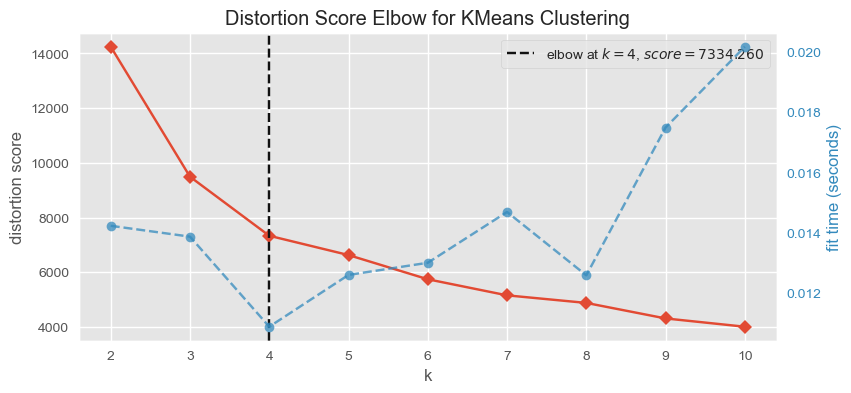

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [60]:
# Quick examination of elbow method to find numbers of clusters to make.
print('Elbow Method to determine the number of clusters to be formed:')
Elbow_M = KElbowVisualizer(KMeans(), k=10)
Elbow_M.fit(PCA_ds)
Elbow_M.show()

the optimal number of clusters needed is 4

In [61]:
#Performing bivariant cluster analysis described by the annual income and spending score variable
cluster = KMeans(n_clusters = 4)
cluster.fit(PCA_ds)
df["Cluster"] = cluster.labels_
df.head()

,Age,Is_Parent,Education,Income,Children,Kidhome,Teenhome,Family_Size,Customer_for,Recency,...,NumWebVisitsMonth,AcceptedCmp3,accepted_campaign_flag,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,Cluster
0,68,0,Graduate,58138.0,0,0,0,1,13,58,...,7,0,0,0,0,0,0,0,1,1
1,71,1,Graduate,46344.0,2,1,1,3,11,38,...,5,0,0,0,0,0,0,0,0,2
2,60,0,Graduate,71613.0,0,0,0,2,13,26,...,4,0,0,0,0,0,0,0,0,1
3,41,1,Graduate,26646.0,1,1,0,3,11,26,...,6,0,0,0,0,0,0,0,0,0
4,44,1,Postgraduate,58293.0,1,1,0,3,11,94,...,5,0,0,0,0,0,0,0,0,3


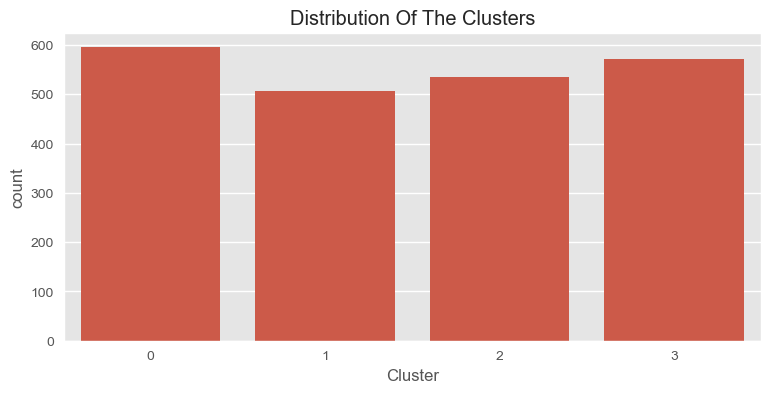

In [64]:
#Plotting countplot of clusters to check distribution of the clusters 
ax = sn.countplot(x=df["Cluster"])
plt.title("Distribution Of The Clusters")
plt.show()

clusters seems to be evenly distributed.

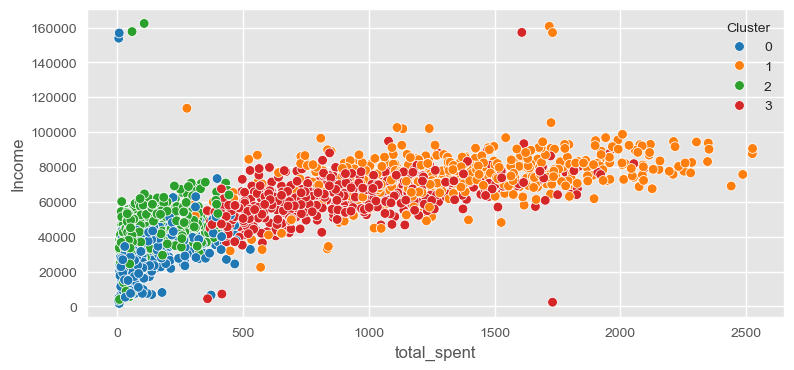

In [65]:

#performing scatter plot to visualize the clusters 
sn.scatterplot(data = df, x = "total_spent", y = "Income", 
               hue = "Cluster", palette= "tab10")
plt.show()

it appears cluster 0 and 2, spend lesser and has lower income compared to the rest of the clusters 

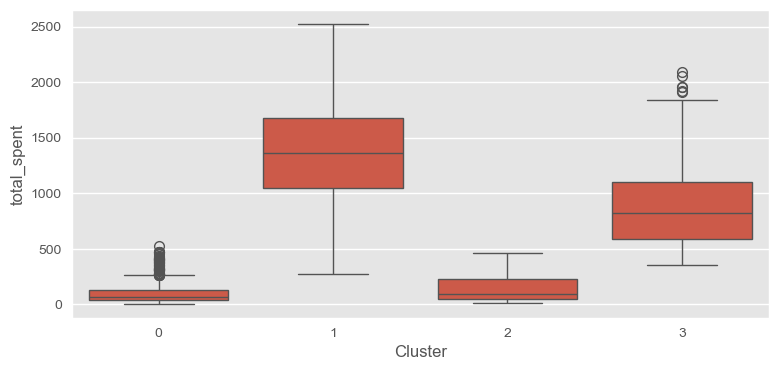

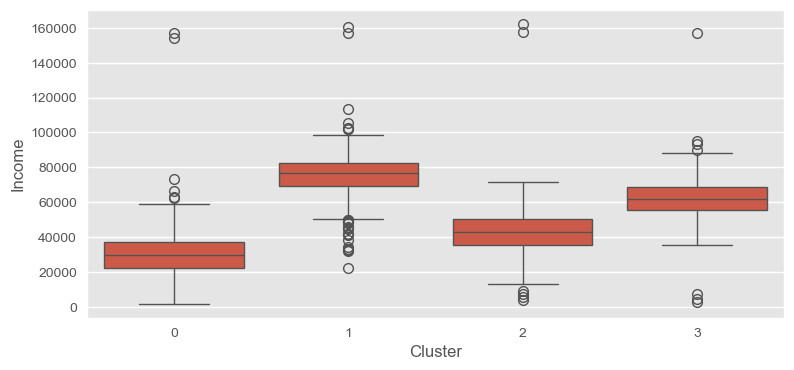

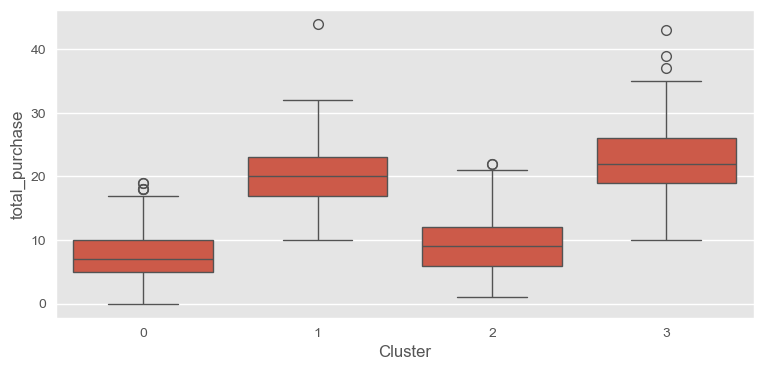

In [68]:
#Performing a Boxplot to display the distribution of the clusters based on the minimum, first quartile, median, third quartile, and maximum.
columns = ['total_spent', 'Income', 'total_purchase']
for i in columns:
    plt.figure()
    sn.boxplot(data = df, y = df[i], x = df["Cluster"])
plt.show()

## cluster profiling 

Now that we’ve established customer clusters and analyzed their purchasing behaviors, let’s dive deeper into who these customers are. By profiling each cluster, we can identify our star customers—those driving the most value—and pinpoint groups that may require targeted marketing efforts to enhance engagement.

To achieve this, I’ll visualize key demographic and behavioral features across clusters. These insights will help us tailor strategies, ensuring optimal resource allocation for the retail store’s marketing team.

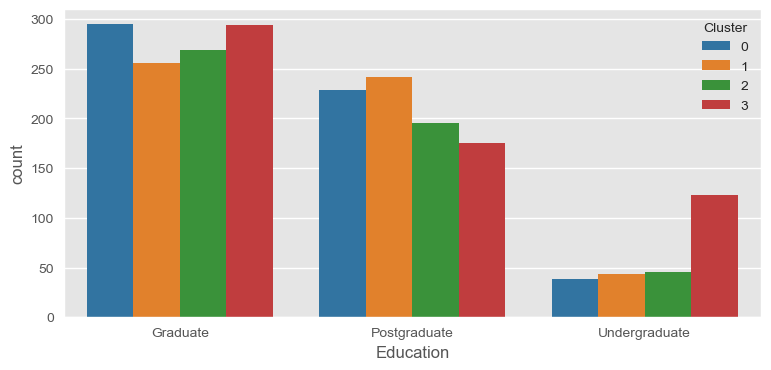

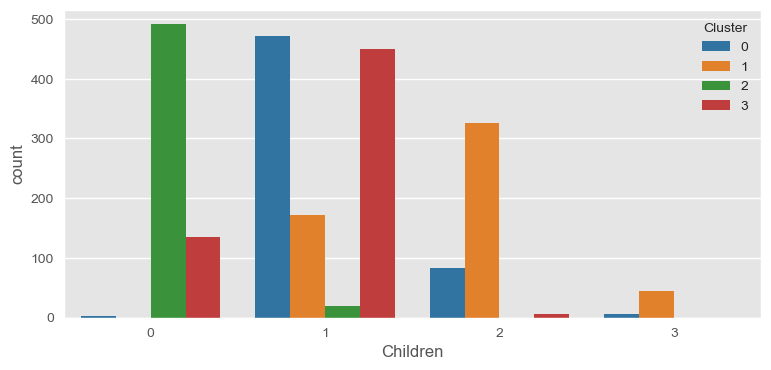

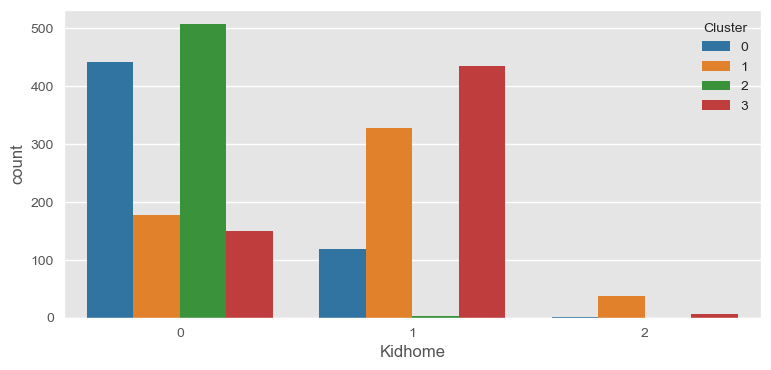

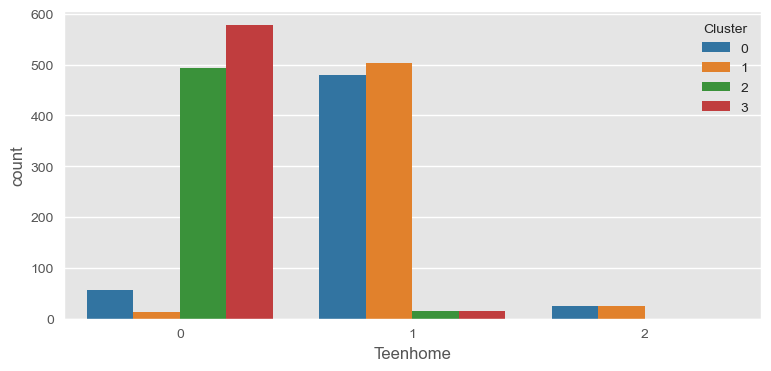

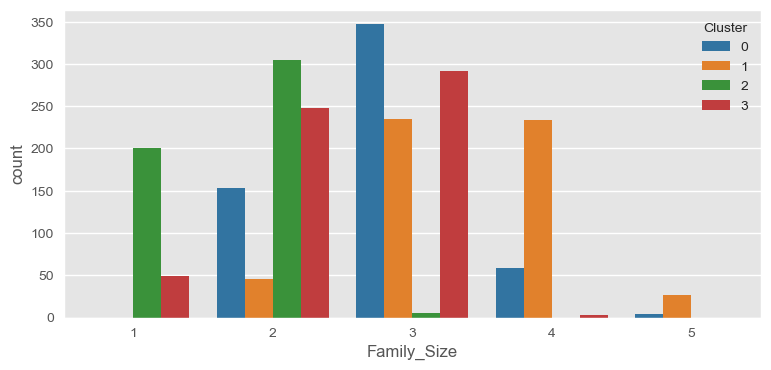

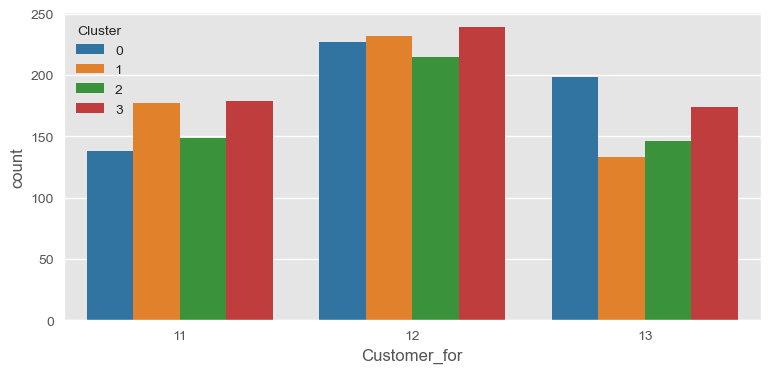

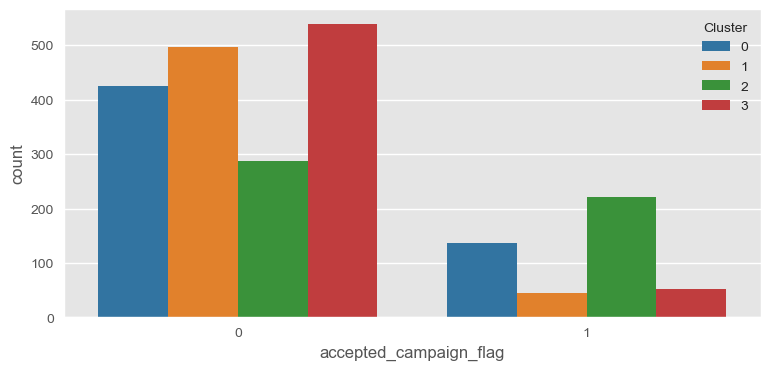

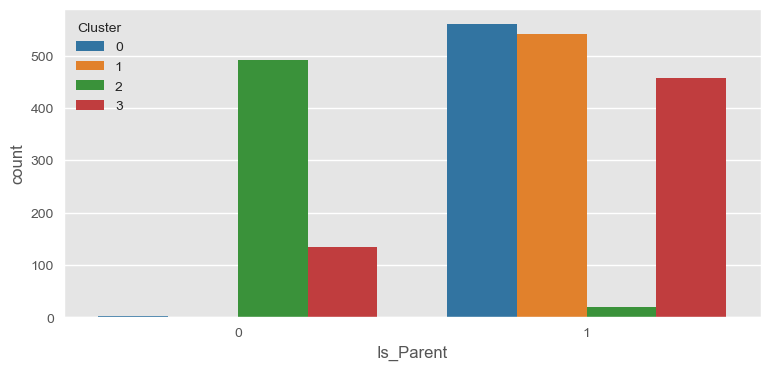

In [23]:
personal_trait = ['Education', 'Children', 'Kidhome', 'Teenhome', 'Family_Size', 'Customer_for', 'accepted_campaign_flag', 'Is_Parent']

for i in personal_trait:
    sn.countplot(x=df[i],hue=df["Cluster"], palette="tab10")
    plt.show()

1. Education by Cluster
Cluster 3 seems more evenly distributed across education levels compared to others.
Clusters 0 and 1 are heavily dominated by Graduate and Postgraduate individuals.
Cluster 3 may represent a more diverse or entry-level demographic due to the relatively high number of undergraduates.
2. accepted_campaign_flag
Cluster 2 is the most responsive to campaigns.
Cluster 3, despite being large in count, is least engaged in campaign participation.
This suggests Cluster 2 might be the ideal target for future marketing efforts, while Cluster 3 may require a different strategy or might be less profitable to target.
3. Is_Parent
Being a parent is a distinguishing feature between the clusters. Clusters 0 and 1 are strongly associated with parenthood, while Cluster 2 is not.
4. Family Size
Cluster 1 likely represents larger families, Cluster 2 smaller families or singles, Cluster 0 moderate-sized families, and Cluster 3 somewhere in between.
5. Children
Cluster 2 is likely young adults/singles or DINKs (dual income, no kids).
Cluster 1 represents more established, larger families.
Cluster 0 and 3 are mid-sized families with around 1 child.

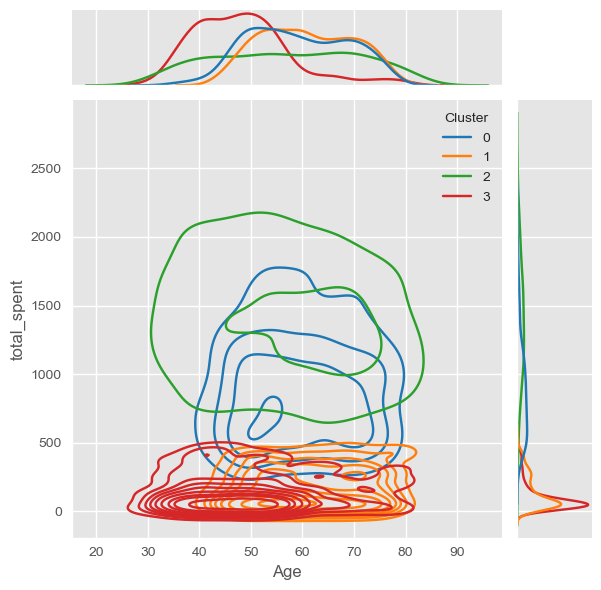

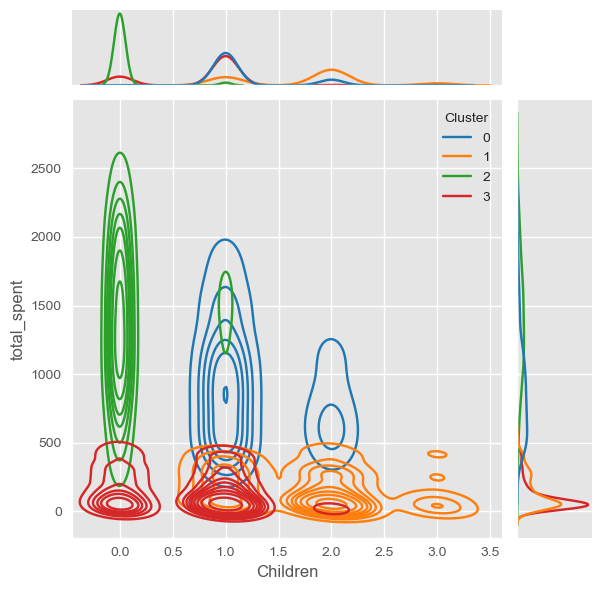

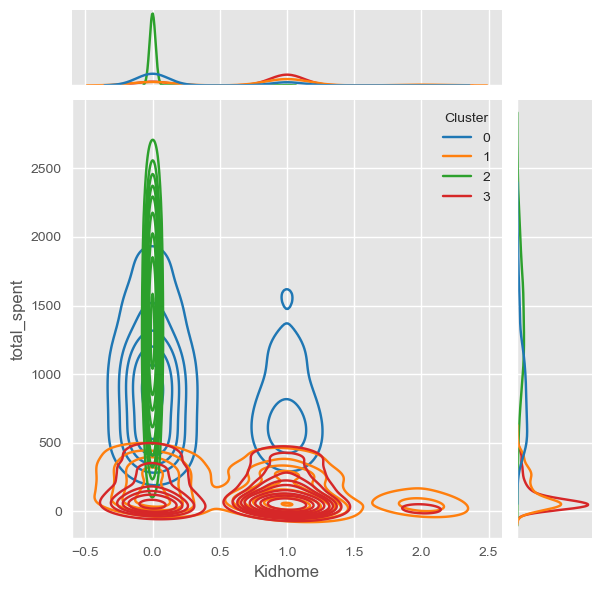

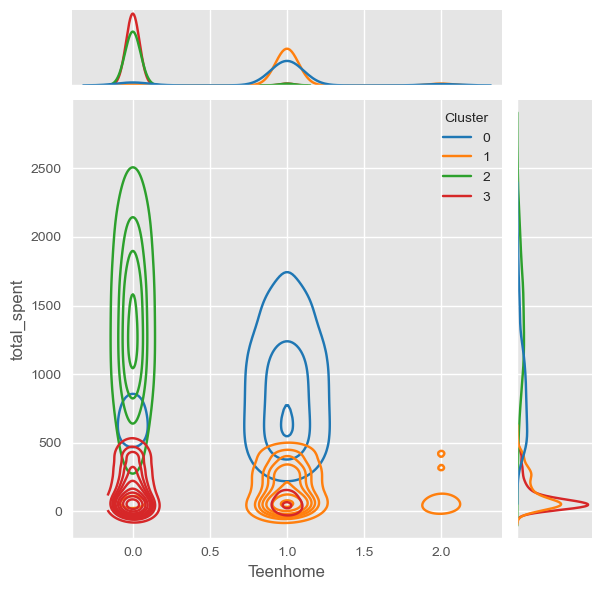

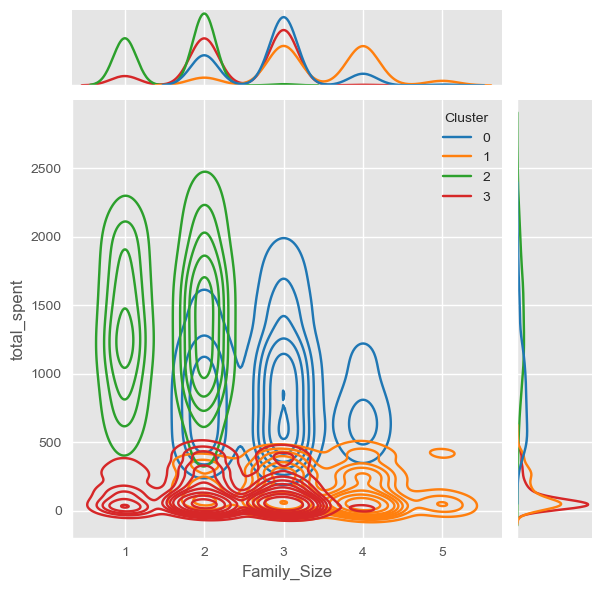

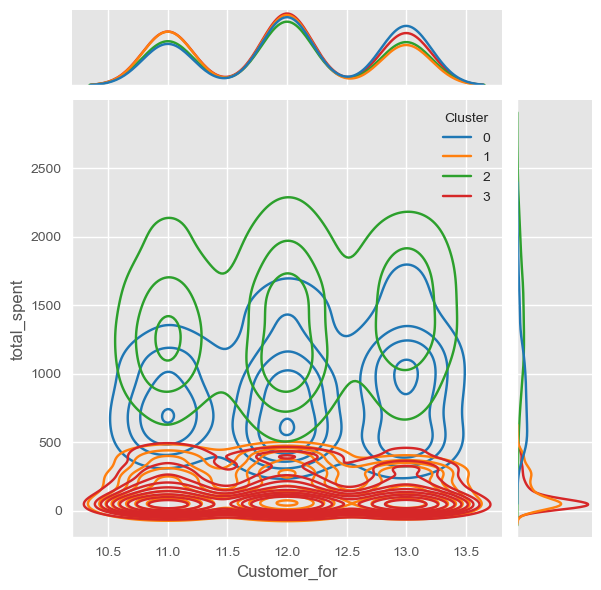

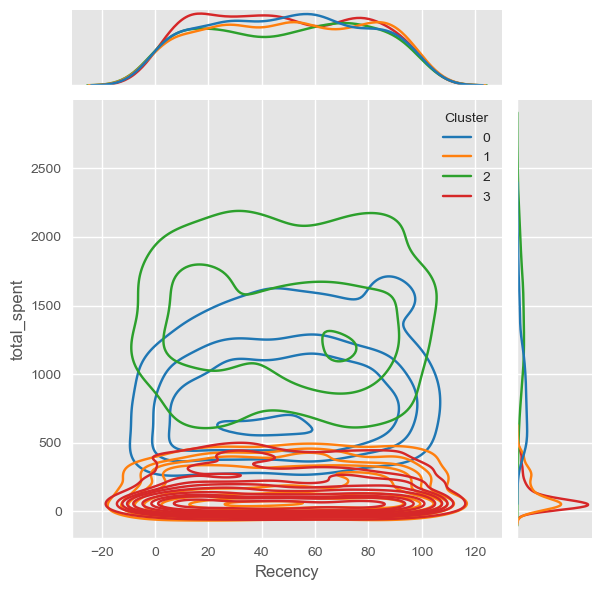

In [24]:
personal_trait = ['Age', 'Children', 'Kidhome', 'Teenhome', 'Family_Size', 'Customer_for', 'Recency']

for i in personal_trait:
    sn.jointplot(x=df[i], y=df["total_spent"], hue=df["Cluster"], kind="kde", palette="tab10")
    plt.show()

## REPORT 

## Introduction

The objective of this clustering analysis is to better understand customer segments in order to optimize campaign targeting, enhance personalization strategies, and ultimately drive business growth. Through exploratory data analysis and unsupervised machine learning (clustering), we identify behavioral patterns, spending profiles, and demographics that define customer behavior.

## Methodology

Data Exploration
Exploratory Data Analysis (EDA) was conducted to identify initial trends across demographics (age, income, family size) and behavior (spending, purchases, tenure).

Feature Selection
Variables such as income, total purchases, total spent, age, children, family size, tenure, and campaign acceptance were used.

Clustering Technique
An unsupervised clustering approach was used to segment customers into 4 clusters, evenly distributed based on selected features.

Evaluation Criteria
Cluster behavior was examined using distributions of total spent, income, children, education, and campaign response.

## Exploratory Data Analysis (EDA) – Key Findings

Age vs. Campaign Acceptance: Age range for both acceptors and non-acceptors is similar (40–70). Age alone doesn't significantly impact campaign responsiveness.

Income vs. Campaign Acceptance: Majority earn <150,000. High-income individuals are rare. Income alone does not distinguish acceptors.

Customer Tenure vs. Acceptance: Peaks at 11–13 years for both groups, indicating tenure is not a major factor.

Total Purchases & Spending: Higher purchases and spending are more associated with campaign acceptance.

Family Size, Children, and Recency: Weak or no clear differentiation between acceptors and non-acceptors based on these features.



## Correlation Analysis

Strong Positive Correlations:

Income ↔ Total Spent (0.79)

Total Purchases ↔ Total Spent (0.76)

Strong Negative Correlations:

Is_Parent ↔ Income (-0.40)

Kidhome ↔ Income (-0.51)

Is_Parent ↔ Total Spent (-0.52)

Weak Correlations:

Age and Tenure show minimal linear correlation with other variables.

Campaign acceptance has weak correlations with most individual features.

## Clustering Results

General Notes:
4 clusters identified with reasonably even distribution.

Differentiation emerges across income, spending, family structure, and marketing responsiveness.


## Cluster Profiles

Cluster 0
Age: 40–78

Spending: Mid to high (500–1700)

Family: Moderate family size (2–4), 1–2 children, 1 teen

Kids at home: 0–1

Campaign response: Moderate

Insight: Middle-aged moderate spenders with small families.

Cluster 1
Age: 40–80

Spending: Mostly ≤ 500

Purchases: High

Income: Moderate-high

Family: Largest family sizes (up to 5), often parents with 1–3 children and teens

Campaign response: Low

Insight: Established families, high purchase frequency but low per-transaction spend.

Cluster 2
Age: 30–70

Spending: 500–2000, skewed toward higher values

Family: Smallest (1–2), often single or couples without children

Kids/Teens: 0

Campaign response: Highest

Insight: Young adults or DINKs, high-value customers, top marketing targets.

Cluster 3
Age: 30–55

Spending: Lowest (<300)

Family: Smaller (1–4), often 0–1 children

Education: Most diverse (includes many undergraduates)

Campaign response: Lowest

Insight: Diverse and younger group, low engagement and spending, likely less profitable.



## Key Insights

Cluster 2 is the most responsive to marketing and spends the most — prime for campaign targeting.

Cluster 1 represents loyal, high-frequency shoppers with large families — candidates for retention programs.

Cluster 0 behaves conservatively — may be upsold with personalized offers.

Cluster 3 has low ROI potential — alternative strategies needed or de-prioritization.

## Recommendations

Prioritize Cluster 2 for high-ROI marketing campaigns and promotions.

Design family-centric offers for Cluster 1 — loyalty programs, bulk discounts, etc.

Explore upsell and cross-sell strategies for Cluster 0, especially for moderately engaged customers.

Re-evaluate targeting for Cluster 3 — consider alternative channels or non-campaign-based engagement.

## Suggestions for Further Analysis

Apply dimensionality reduction (e.g., PCA) to visualize cluster separability.

Consider clustering with behavioral features only (e.g., spending, purchases) to remove demographic noise.

Explore time-based analysis — how cluster membership or behavior changes over time.

Validate clusters with external labels (e.g., customer profitability, churn) if available.

## Conclusion

This clustering analysis has successfully segmented customers into meaningful groups with distinct behaviors and engagement levels. The insights derived here enable more targeted, efficient marketing strategies and better resource allocation. With Cluster 2 showing high potential and Cluster 1 showing reliability, future campaigns can be more focused and data-driven.